# DETR - Detection Transformer
Reference: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb


Original DETR paper: https://arxiv.org/abs/2005.12872

Original DETR repo: https://github.com/facebookresearch/detr


In [1]:
#!python --version

In [2]:
#!python -m pip install --upgrade pip

#!pip install supervision==0.3.0

#!pip install transformers

#!pip install pytorch-lightning

#!pip install timm

#!pip install cython

#!pip install pycocotools

#!pip install scipy

#!pip install roboflow

In [3]:
!pip --version

/var/lib/oar/.batch_job_bashrc: line 5: /home/echamseddine/.bashrc: No such file or directory
pip 25.1.1 from /home/echamseddine/.local/lib/python3.9/site-packages/pip (python 3.9)


In [4]:
import torch
torch.__version__

'2.3.1'

In [5]:
import supervision as sv
import transformers

sv.__version__ , transformers.__version__

/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('0.3.0', '4.52.4')

In [6]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.5.2


## Create COCO data loaders

### About dataset:

#### number of classes - 4  ['angle', 'fracture', 'line', 'messed_up_angle'


![image.png](attachment:3c3cf0f7-faa8-477c-b8df-40ff4415b187.png)]

![image.png](attachment:d4d14b07-49fc-4d16-b0c0-702e6620cd17.png)

In [7]:
import os
import torchvision
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = 'bone-fracture-detection-computer-vision-project/BoneFractureYolo8/'

ANNOTATION_FILE_NAME = "annotations.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train/images")
VAL_DIRECTORY = os.path.join(dataset, "valid/images")
TEST_DIRECTORY = os.path.join(dataset, "test/images")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 3631
Number of validation examples: 348
Number of test examples: 169


Trying image #3535...
No annotations for this image, trying another one...
Trying image #1446...
No annotations for this image, trying another one...
Trying image #1311...
Image #1311 has 1 annotation(s).


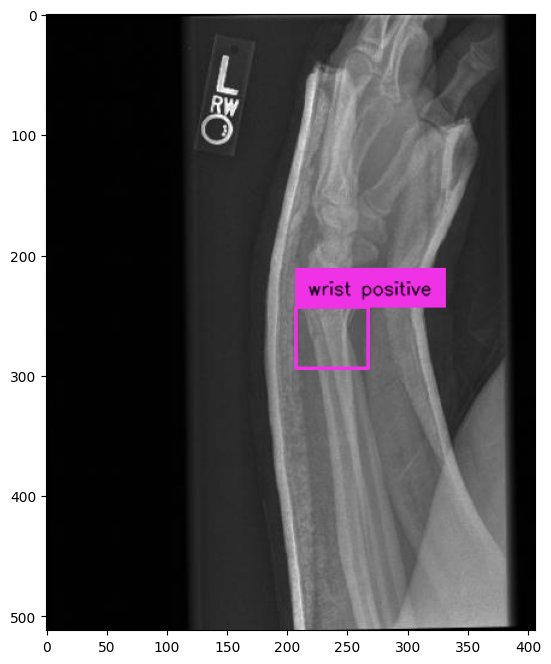

In [8]:
import random
import cv2
import numpy as np
import os

# Visualize if dataset is loaded properly

# Get category mapping once
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

# Try loading an image with annotations
while True:
    image_ids = TRAIN_DATASET.coco.getImgIds()
    image_id = random.choice(image_ids)
    print(f"Trying image #{image_id}...")

    annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
    if annotations:
        print(f"Image #{image_id} has {len(annotations)} annotation(s).")
        break
    else:
        print("No annotations for this image, trying another one...")

# Load image
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)

# Convert annotations to detections
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# Prepare labels
labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _ in detections
]

# Annotate and show
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (8, 8))


In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The DETR model is loaded using the Hugging Face Transformers library

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [12]:
#!pip install --upgrade rich

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar
MAX_EPOCHS = 200
trainer = Trainer(max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5, callbacks=[RichProgressBar()])
trainer.fit(model)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unl

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃   ┃ Name  ┃ Type                   ┃ Params ┃ Mode ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━┩
│ 0 │ model │ DetrForObjectDetection │ 41.5 M │ eval │
└───┴───────┴────────────────────────┴────────┴──────┘

Trainable params: 41.3 M                                                                                           
Non-trainable params: 222 K                                                                                        
Total params: 41.5 M                                                                                               
Total estimated model params size (MB): 166                                                                        
Modules in train mode: 0                                                                                           
Modules in eval mode: 399

/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conn
ector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.

/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying
to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations,
use `self.log(..., batch_size=batch_size)`.

/home/echamseddine/.conda/envs/torchenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_conn
ector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.

# Save and load model

In [ ]:
MODEL_PATH = '/home/echamseddine/Object_Detection'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
CONFIDENCE_TRESHOLD = 0.1



# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()
